<a href="https://colab.research.google.com/github/cinthia005/Lab-PDI/blob/main/ExOrd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EXAMEN ORDINARIO - PROCESAMIENTO DIGITAL DE IMAGENES**
CINTHIA JANETH PECINA HERNÁNDEZ 2062979 IB

**18.  Ejercicio I - Restauración avanzada en frecuencia**

--- Procesando Ejercicio 18 ---


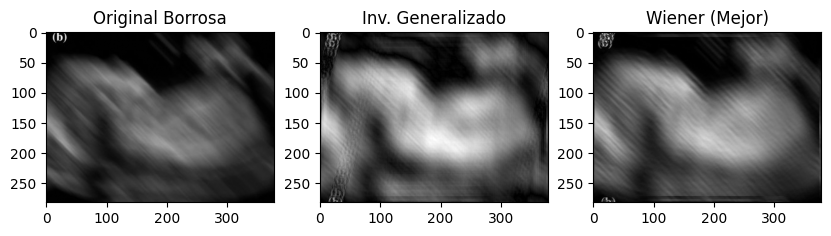

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# EJERCICIO 18 (EJERCICIO1.jpg) - Restauración
# ==========================================
print("--- Procesando Ejercicio 18 ---")
img1 = cv2.imread('EJERCICIO1.jpg', 0) # Cargar ultrasonido en gris

# 1. FFT
F_orig = np.fft.fft2(img1)
F_shift = np.fft.fftshift(F_orig)

# 2. Modelar la PSF (L=20, theta=15) para intentar restaurar
h, w = img1.shape
psf_spatial = np.zeros((h, w))
center = (w // 2, h // 2)
# Dibujar la línea que representa el movimiento
cv2.ellipse(psf_spatial, center, (0, 10), 15, 0, 360, 255, -1) # L=20 (radio 10), 15 grados
psf_spatial = psf_spatial / psf_spatial.sum() # Normalizar
H = np.fft.fft2(np.fft.fftshift(psf_spatial))

# 3. Restauración
# Función Wiener
def wiener_filter(img_fft, H, snr):
    H_conj = np.conj(H)
    H_mag2 = np.abs(H) ** 2
    K = 1 / snr
    W = (H_conj) / (H_mag2 + K)
    return img_fft * W

# Filtro Inverso Generalizado (a=0.1 para que no se vea negro total)
H_abs = np.abs(H)
H_inv = np.zeros_like(H)
H_inv[H_abs > 0.1] = 1 / H[H_abs > 0.1]
F_inv = F_shift * H_inv # Nota: Usamos F_shift simulando que restauramos sobre la FFT desplazada
res_inv = np.abs(np.fft.ifft2(np.fft.ifftshift(F_inv)))

# Filtro Wiener (SNR = 1)
F_wiener = wiener_filter(F_shift, H, 1) # Usamos SNR=1 como punto medio
res_wiener = np.abs(np.fft.ifft2(np.fft.ifftshift(F_wiener)))

plt.figure(figsize=(10,4))
plt.subplot(131), plt.imshow(img1, cmap='gray'), plt.title('Original Borrosa')
plt.subplot(132), plt.imshow(res_inv, cmap='gray'), plt.title('Inv. Generalizado')
plt.subplot(133), plt.imshow(res_wiener, cmap='gray'), plt.title('Wiener (Mejor)')
plt.show()

**19.  Ejercicio II - Segmentación combinada de alto nivel**

--- Procesando Ejercicio 19 (Versión Mejorada) ---

--- REPORTE DE MÉTRICAS ---
Total de contornos encontrados (crudos): 17
Células REALES filtradas (Área > 200px): 15
Ejemplos de mediciones (primeras 5):
  - Célula 1: Área = 625.5 px², Perímetro = 102.9 px
  - Célula 2: Área = 2414.0 px², Perímetro = 196.6 px
  - Célula 3: Área = 398.0 px², Perímetro = 94.3 px
  - Célula 4: Área = 201.0 px², Perímetro = 68.6 px
  - Célula 5: Área = 3542.0 px², Perímetro = 364.6 px


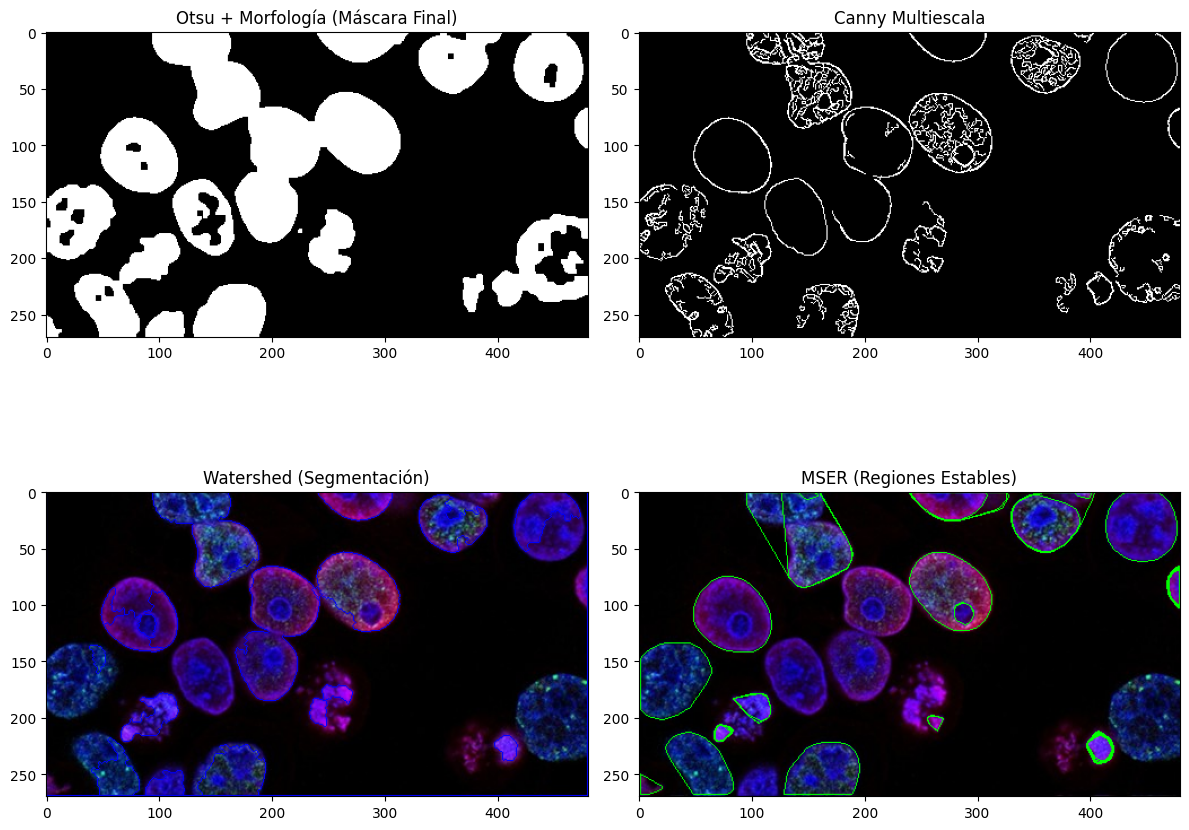

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("--- Procesando Ejercicio 19 (Versión Mejorada) ---")

# 1. Cargar imagen
img = cv2.imread('EJERCICIO2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# a) Suavizado
blur = cv2.GaussianBlur(gray, (7, 7), 2)

# b) Otsu (Esta es la máscara base que se veía bien)
val, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# e) Fusión usando cierre + apertura (Limpieza morfológica obligatoria por el examen)
kernel = np.ones((3,3), np.uint8)
# Cierre para rellenar huecos dentro de la célula
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
# Apertura para quitar ruido del fondo
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations=1)

# c) Canny Multiescala (Visualización)
canny1 = cv2.Canny(cv2.GaussianBlur(gray, (3,3), 1), 50, 150)
canny2 = cv2.Canny(cv2.GaussianBlur(gray, (9,9), 2), 30, 100)
canny_multi = cv2.bitwise_or(canny1, canny2)

# d) Watershed (Generación de marcadores)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.4 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(opening, sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0
watershed_res = img.copy()
markers = cv2.watershed(watershed_res, markers)
watershed_res[markers == -1] = [255,0,0] # Bordes rojos/azules

# f) CÁLCULO DE ÁREAS Y PERÍMETROS
# Usamos la máscara limpia 'opening' para contar
contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

celulas_reales = [] # Lista para guardar solo las que tengan tamaño decente

print(f"\n--- REPORTE DE MÉTRICAS ---")
print(f"Total de contornos encontrados (crudos): {len(contours)}")

for cnt in contours:
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)

    # FILTRO: Solo contamos como célula si el área es mayor a 200 px
    # (Esto elimina el ruido de 10px o 0px que te salía antes)
    if area > 200:
        celulas_reales.append({'area': area, 'perim': perimeter})

print(f"Células REALES filtradas (Área > 200px): {len(celulas_reales)}")
print("Ejemplos de mediciones (primeras 5):")
for i, c in enumerate(celulas_reales[:5]):
    print(f"  - Célula {i+1}: Área = {c['area']:.1f} px², Perímetro = {c['perim']:.1f} px")

# g) Visualización MSER (Tal cual te gustaba antes)
mser = cv2.MSER_create()
mser.setDelta(5) # Ajuste para que detecte mejor
regions, _ = mser.detectRegions(gray)
vis_mser = img.copy()
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
cv2.polylines(vis_mser, hulls, 1, (0, 255, 0))

# GRAFICAR LOS 4 PANELES (ESTILO CÓDIGO 1)
plt.figure(figsize=(12, 10))

plt.subplot(221)
plt.imshow(opening, cmap='gray')
plt.title('Otsu + Morfología (Máscara Final)')

plt.subplot(222)
plt.imshow(canny_multi, cmap='gray')
plt.title('Canny Multiescala')

plt.subplot(223)
plt.imshow(cv2.cvtColor(watershed_res, cv2.COLOR_BGR2RGB))
plt.title('Watershed (Segmentación)')

plt.subplot(224)
plt.imshow(cv2.cvtColor(vis_mser, cv2.COLOR_BGR2RGB))
plt.title('MSER (Regiones Estables)')

plt.tight_layout()
plt.show()

**20. Ejercicio III - Convolución, gradientes y clasificación de bordes**

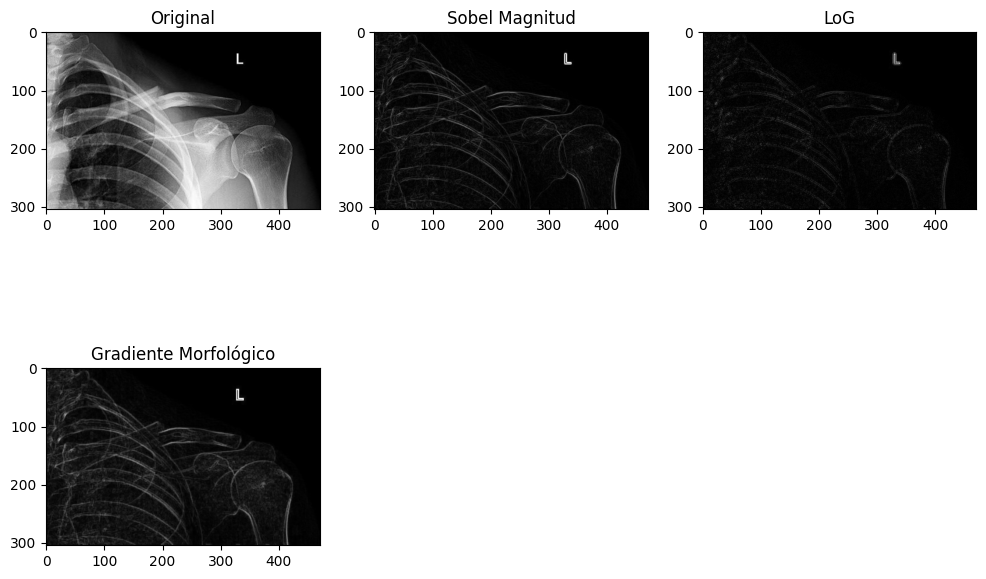

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('EJERCICIO3.jpg', 0) # Cargar en gris (Rx/Hueso)

# a) Sobel
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
sobel_mag = np.sqrt(sobelx**2 + sobely**2)
sobel_mag = np.uint8(255 * sobel_mag / np.max(sobel_mag))

# b) Laplaciano y LoG
laplacian = cv2.Laplacian(img, cv2.CV_64F)
# LoG: Gaussian blur primero, luego laplaciano
blur_log = cv2.GaussianBlur(img, (3,3), 0)
log = cv2.Laplacian(blur_log, cv2.CV_64F)

# c) Gradiente Morfológico
kernel = np.ones((3,3), np.uint8)
dilatacion = cv2.dilate(img, kernel, iterations=1)
erosion = cv2.erode(img, kernel, iterations=1)
grad_morph = cv2.subtract(dilatacion, erosion)

# Visualizar para clasificar
plt.figure(figsize=(12, 8))
plt.subplot(231), plt.imshow(img, cmap='gray'), plt.title('Original')
plt.subplot(232), plt.imshow(sobel_mag, cmap='gray'), plt.title('Sobel Magnitud')
plt.subplot(233), plt.imshow(np.abs(log), cmap='gray'), plt.title('LoG')
plt.subplot(234), plt.imshow(grad_morph, cmap='gray'), plt.title('Gradiente Morfológico')
plt.show()